# <center>ASTR4004/8004 - Inference - Part 5</center> 

## Simulation-based inference

Our goal is to perform inference on a model's parameters $\theta$ given observations $D$ and learn the posterior distribution $P(\theta|D)$. Normally, we do this with Bayes' rule:
$$
P(\theta|D)=P(D|\theta)\frac{P(\theta)}{P(D)},
$$
which relies on the likelihood function $P(D|\theta)$.

<font color='red'> However, what if we don't know the likelihood or there is no functional form to evaluate the likelihood?</font>

Remember our model can reproduce different sets of output $D'$ for given $\theta$. This means that we can measure *the frequecy of those outputs that reproduce/match the real data ($D$) to obtain a probability $P(\theta|D)$*, which is the posterior probability. 

This notebook shows a simple example of linear regression using `sbi` and its backend PyTorch (`torch`).

## Useful packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sbi.utils import BoxUniform
from sbi.analysis import pairplot
from sbi.inference import infer
import corner

/Users/yqin/virtualenvs/astr4004_8004/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Data (D) and the task
We will be given a dataset `(x, y)` and the task is to fit a linear function of `y=mx+b` to these data points.

Text(0, 0.5, 'y')

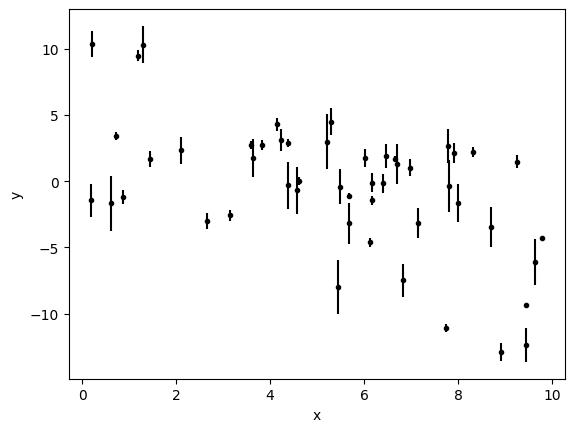

In [2]:
# Set seed for reproducibility
np.random.seed(0)

# Generate dataset (100 data points) following y = m * x +b
m_true = -0.9
b_true = 4.3
f_true = 2.0

n_data = 50
x = np.sort(10 * np.random.random(n_data)) # uniform random points between 0 and 10
yerr = 0.1 + 2.0 * np.random.random(n_data) # generate a uniform random error (standard deviation) between 0.1 and 5.1
y = m_true * x + b_true # array of exact y values correspond to x for the true parameters.
y += yerr * np.random.standard_normal(n_data) # perturb the exact y values according to yerr
y += np.abs(f_true * y) * np.random.standard_normal(n_data) #random noise that depends on y

plt.errorbar(x, y, yerr=yerr, fmt='k.')
plt.xlabel('x')
plt.ylabel('y')

## Propose your model
* It "seems" that our dataset $D$ follows a linear correlation.
* We also have some prior knowledge on the level of the error and know there is an error term which depends on `y` (e.g. thermal noise $\propto$ thermal energy)
* So we decide to fit it against a linear function of `y=mx+b`.
* We will also consider the extra error term ($\ln{f}$) when writing the likelihood.
* Therefore, out parameter $\theta$ corresponds to ($m$, $b$, $\ln{f}$).

## Define the prior

In [3]:
m_min, m_max = -5, 5
b_min, b_max = -10, 10
lnf_min, lnf_max = -6, 6
prior = BoxUniform(
    low=torch.tensor([m_min, b_min, lnf_min]),
    high=torch.tensor([m_max, b_max, lnf_max])
)

## Define the simulator/model

In [4]:
def simulator(params):
    y = params[0] * x + params[1]
    yerr = 0.1 + 2.0 * np.random.random(n_data)
    y += yerr * np.random.standard_normal(n_data)
    y += np.exp(params[2]) * np.abs(y) * np.random.standard_normal(n_data)

    return y

## Sample the parameter space and estimate the density distribution

In [17]:
posterior = infer(
    simulator,
    prior,
    method='SNPE',
    num_simulations=100000,
    )

  0%|          | 0/100000 [00:00<?, ?it/s]

 Neural network successfully converged after 129 epochs.

## Evaluate the posterior by conditioning probability on the data

In [6]:
# Generate the 3D grid of coordinates
ms = np.linspace(m_min, m_max, 50, dtype=np.float32)
bs = np.linspace(b_min, b_max, 50, dtype=np.float32)
lnfs = np.linspace(lnf_min, lnf_max, 50, dtype=np.float32)

m_grid, b_grid, lnf_grid = np.meshgrid(ms, bs, lnfs, indexing='ij')

# Reshape the grids into 1D arrays and stack them into a grid of points
grids = torch.from_numpy(np.vstack([m_grid.ravel(), b_grid.ravel(), lnf_grid.ravel()]).T)
log_prob = posterior.log_prob(grids, y).reshape(*m_grid.shape)
prob = np.exp(log_prob).numpy()

## Plot the marginal posterior distribution

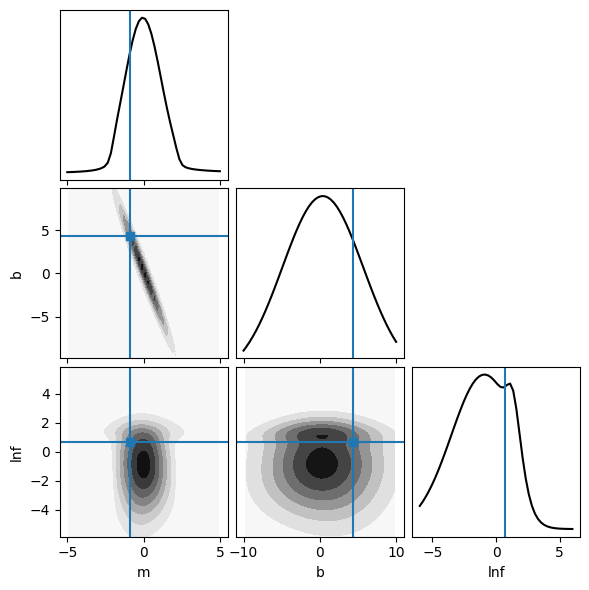

In [7]:
# Compute the marginal distributions by summing over the axes
# Marginal over m, b, and lnf respectively
m_marginal = np.sum(np.sum(prob, axis=2), axis=1)  # Sum over b and lnf axes
b_marginal = np.sum(np.sum(prob, axis=2), axis=0)  # Sum over m and lnf axes
lnf_marginal = np.sum(np.sum(prob, axis=1), axis=0)  # Sum over m and b axes

# Compute 2D marginal distributions (joint distributions)
mb_marginal = np.sum(prob, axis=2)  # Sum over lnf to get m-b marginal
mlnf_marginal = np.sum(prob, axis=1)  # Sum over b to get m-lnf marginal
blnf_marginal = np.sum(prob, axis=0)  # Sum over m to get b-lnf marginal

# Create a 3x3 corner plot
fig, axes = plt.subplots(3, 3, figsize=(6, 6), sharex='col')

# List of labels
labels = ['m', 'b', 'lnf']

# Diagonal: Plot the 1D marginal distributions
axes[0, 0].plot(ms, m_marginal, c='k')
axes[1, 1].plot(bs, b_marginal, c='k')
axes[2, 2].plot(lnfs, lnf_marginal, c='k')
axes[0, 0].set_yticks([])
axes[1, 1].set_yticks([])
axes[2, 2].set_yticks([])
axes[0, 0].axvline(m_true)
axes[1, 1].axvline(b_true)
axes[2, 2].axvline(np.log(f_true))
axes[2, 2].set_xlabel('lnf')

# Off-diagonal: Plot the 2D marginal distributions as heatmaps
# m vs b (top left corner)
axes[1, 0].contourf(mb_marginal.T, origin='lower', extent=[m_min, m_max, b_min, b_max], cmap='Greys')
axes[1, 0].set_ylabel('b')
axes[1, 0].axhline(b_true)
axes[1, 0].axvline(m_true)
axes[1, 0].scatter(m_true, b_true, marker='s')

# m vs lnf (bottom left corner)
axes[2, 0].contourf(mlnf_marginal.T, origin='lower', extent=[m_min, m_max, lnf_min, lnf_max], cmap='Greys')
axes[2, 0].set_xlabel('m')
axes[2, 0].set_ylabel('lnf')
axes[2, 0].axhline(np.log(f_true))
axes[2, 0].axvline(m_true)
axes[2, 0].scatter(m_true, np.log(f_true), marker='s')

# b vs lnf (bottom middle)
axes[2, 1].contourf(blnf_marginal.T, origin='lower', extent=[b_min, b_max, lnf_min, lnf_max], cmap='Greys')
axes[2, 1].set_xlabel('b')
axes[2, 1].set_ylim(axes[2, 0].get_ylim())
axes[2, 1].set_yticks([])
axes[2, 1].axhline(np.log(f_true))
axes[2, 1].axvline(b_true)
axes[2, 1].scatter(b_true, np.log(f_true), marker='s')

# Hide the unused plots (upper right plots)
axes[0, 1].axis('off')
axes[0, 2].axis('off')
axes[1, 2].axis('off')

# Adjust layout for better viewing
plt.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

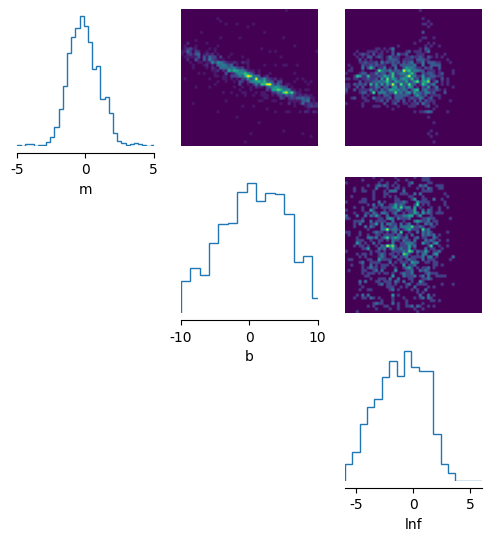

In [9]:
## sbi has a built-in routine to make corner plot
samples = posterior.sample((1000,), x=y)
pairplot(samples, limits=[[m_min,m_max],[b_min,b_max], [lnf_min,lnf_max]], figsize=(6, 6), labels=['m','b','lnf']);

## plot the posterior against data

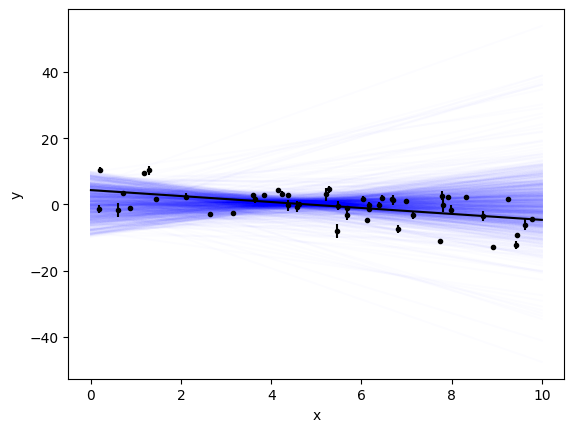

In [10]:
x_ref = np.linspace(0,10, 100)
for sample in samples:
    m,b,lnf = sample
    plt.plot(x_ref, m*x_ref + b, c="blue", alpha=0.01)
    
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_ref, m_true * x_ref + b_true, "k")
plt.xlabel('x')
plt.ylabel('y');

## Amortization

Amortization means that you train one neural network that can infer parameters for many different observations — not just one.

Think of “amortized” like amortized cost in finance — you pay a large upfront cost once (training) and then reuse it cheaply later.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

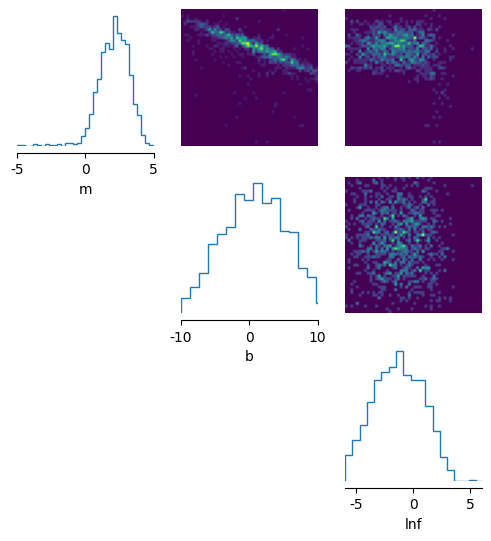

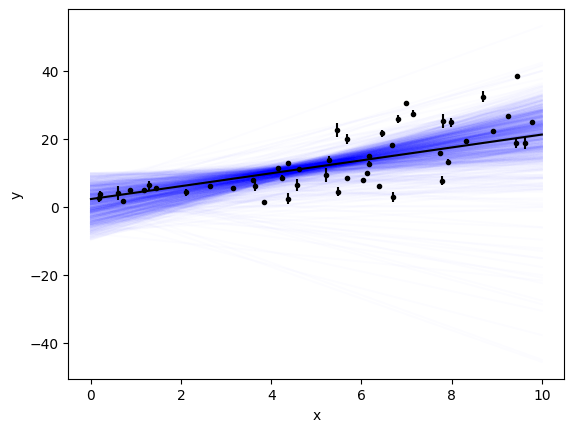

In [12]:
# Set seed for reproducibility
np.random.seed(0)

# Generate a different dataset (100 data points) following y = m * x +b
m_true = 1.9
b_true = 2.3
f_true = 0.5

y = m_true * x + b_true # array of exact y values correspond to x for the true parameters.
y += yerr * np.random.standard_normal(n_data) # perturb the exact y values according to yerr
y += np.abs(f_true * y) * np.random.standard_normal(n_data) #random noise that depends on y

## sbi has a built-in routine to make corner plot
samples = posterior.sample((1000,), x=y)
pairplot(samples, limits=[[m_min,m_max],[b_min,b_max], [lnf_min,lnf_max]], figsize=(6, 6), labels=['m','b','lnf']);

plt.show()

x_ref = np.linspace(0,10, 100)
for sample in samples:
    m,b,lnf = sample
    plt.plot(x_ref, m*x_ref + b, c="blue", alpha=0.01)
    
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_ref, m_true * x_ref + b_true, "k")
plt.xlabel('x')
plt.ylabel('y');